In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/Uvelka/AnomalyDetection')

# Stage 1
Сегментация данных

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
DATAPAH = '/content/drive/MyDrive/Colab Notebooks/Uvelka/Data/'

In [ ]:
raw_data = pd.read_csv(DATAPAH + 'sensor_data.csv', parse_dates=['timestamp'])

<Axes: >

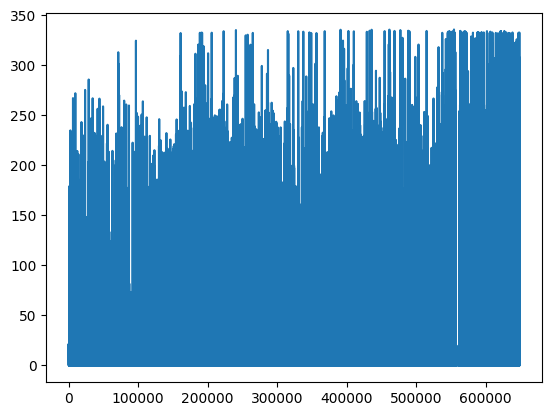

In [ ]:
raw_data.amperage.plot()

In [ ]:
raw_data[(raw_data.device == 'Токовый ремни  Афл3.1') & (raw_data.timestamp > "2024-12-13 00:00:00") & (raw_data.timestamp < "2024-12-14 00:00:00")]

,timestamp,device,amperage
527148,2024-12-13 00:02:18,Токовый ремни Афл3.1,110.117294
527237,2024-12-13 00:04:13,Токовый ремни Афл3.1,20.558908
527290,2024-12-13 00:05:12,Токовый ремни Афл3.1,21.671530
527408,2024-12-13 00:07:29,Токовый ремни Афл3.1,20.135036
527434,2024-12-13 00:08:00,Токовый ремни Афл3.1,4.926829
...,...,...,...
599585,2024-12-13 23:40:58,Токовый ремни Афл3.1,19.905626
600132,2024-12-13 23:51:48,Токовый ремни Афл3.1,15.651458
600343,2024-12-13 23:55:48,Токовый ремни Афл3.1,1.777001
600356,2024-12-13 23:56:03,Токовый ремни Афл3.1,2.650076


In [ ]:
df = raw_data[(raw_data.device == 'Токовый ремни  Афл3.1') & (raw_data.timestamp > "2024-12-12 00:00:00") & (raw_data.timestamp < "2024-12-14 00:00:00")].copy()

In [ ]:
df

,timestamp,device,amperage
453649,2024-12-12 00:06:14,Токовый ремни Афл3.1,20.135036
453662,2024-12-12 00:06:30,Токовый ремни Афл3.1,2.604186
453911,2024-12-12 00:11:19,Токовый ремни Афл3.1,0.005457
453936,2024-12-12 00:11:53,Токовый ремни Афл3.1,0.006135
454014,2024-12-12 00:13:26,Токовый ремни Афл3.1,0.009955
...,...,...,...
599585,2024-12-13 23:40:58,Токовый ремни Афл3.1,19.905626
600132,2024-12-13 23:51:48,Токовый ремни Афл3.1,15.651458
600343,2024-12-13 23:55:48,Токовый ремни Афл3.1,1.777001
600356,2024-12-13 23:56:03,Токовый ремни Афл3.1,2.650076


## Использование модели

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

from sklearn.metrics import log_loss

class TSTrendDetection():
    def __init__(self, bandwidth = 1.0):
        self.bandwidth = bandwidth
        self.mean_shift = MeanShift(bandwidth = self.bandwidth)
        self.scaler = StandardScaler()

    def fit_mean_shift(self, X):
        """
        Mean Shift model fitting.

        Parameters
        ----------
        X: np.ndarray (shape = (samples_count, 2)) :
            first samples timedelta from first sample
            second samples values
        or
        X: pd.DataFrame:
            has column timedelta from first sample
            has column value

        Returns
        -------
        X: np.ndarray (shape = (samples_count, 2)) :
            first samples time
            second samples values
        labels: np.ndarray:
            np.ndarray (shape = (samples_count,))
        clustered_ts_value: list:
            list of np.ndarray of clustered values
        clustered_ts_time: list:
            list of np.ndarray of clustered times
        clustered_ts_cofs: list:
            list of slopes of linear regression
        clustered_ts_intercepts: list:
            list of intercepts of linear regression
        """
        X = X.copy()

        if isinstance(X, pd.DataFrame):
            X.time = X.time.dt.total_seconds()
            X = X[['time', 'value']].values
        if not isinstance(X, np.ndarray):
            raise ValueError("X must be np.ndarray or pd.DataFrame.")

        # Scaling ts data
        scaler = self.scaler

        X_scaled = scaler.fit_transform(X)

        # Clustering ts data
        self.mean_shift.fit(X_scaled)
        labels = self.mean_shift.labels_

        # Linear regressions for clustered data
        clusters = np.unique(labels)

        clustered_ts_values = dict()
        clustered_ts_times = dict()
        clustered_ts_cofs = dict()
        clustered_ts_intercepts = dict()

        for cluster in clusters:
            clustered_series = X[np.where(labels == cluster)]

            times, values, cof, intercept = self._fit_linear_regression(
                clustered_series)

            clustered_ts_values[cluster] = values
            clustered_ts_times[cluster]= times
            clustered_ts_cofs[cluster] = cof[0]
            clustered_ts_intercepts[cluster] = intercept

        return (X, labels, clustered_ts_times, clustered_ts_values,
                clustered_ts_cofs, clustered_ts_intercepts)

    def _fit_linear_regression(self, clustered_series):
        """fit_linear_regression
        Parameters
        ----------
        clustered_series: np.ndarray (shape = (samples of cluster, 2)) :
            first samples time
            second samples values

        Returns
        -------
        X: np.ndarray (shape = (samples_count, 2)) :
            first samples time
            second samples values
        clustered_ts_value: np.ndarray:
            np.ndarray of clustered values
        clustered_ts_time: np.ndarray:
            np.ndarray of clustered times
        clustered_ts_cofs: float:
            slope of a linear regression
        clustered_ts_intercepts: float:
            intercept of a linear regression
        """
        model = LinearRegression()
        model.fit(clustered_series[:, 0].reshape(-1, 1),
                  clustered_series[:, 1].reshape(-1, 1)
                  )

        clustered_ts_value = model.predict(
            clustered_series[:, 0].reshape(-1, 1)
            )
        clustered_ts_time = clustered_series[:, 0]

        # a - slope of a linear regression
        clustered_ts_cofs = model.coef_[0]

        # b - intercept of a linear regression
        clustered_ts_intercepts = model.intercept_

        return (clustered_ts_time, clustered_ts_value,
                clustered_ts_cofs, clustered_ts_intercepts)

    def predict(self, context, model_input, params=None):
        """
        Prediction method for the custom model.

        Parameters:
        -----------
        context : Any
            Ignored in this example. It's a placeholder for additional data or utility methods.

        model_input : tuple
            The input DataFrame or ndarray classified as normal or has anomaly slope.
            and alpha threshold.

        params : dict, optional
            Additional prediction parameters. Ignored.

        Returns:
        --------
        bool
            Has anomaly TS or not.
        """
        return self._predict_internal(model_input[0], model_input[1])

    def _predict_internal(self, X, alpha):
        """
        Prediction using slopes of linear regressions.
        if true then anomaly detected in time series
        """
        _, _, _, _, clustered_ts_cofs, _ = self.fit_mean_shift(X)
        return (np.array(list(clustered_ts_cofs.values())) > alpha).astype(int)

    def downsample(self, X, smoothing_window = None, skip_window = None):
        """
        Method for time series downsampling.

        Parameters:
        -----------
        X : pd.DataFrame
            first column timedelta
            second column float values
        Returns:
        --------
        pd.DataFrame
            downsampled X.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Time series must be a pd.Series.")
        X = X.copy()
        if smoothing_window != None:
            X.value = X.value.rolling(window=smoothing_window,
                                                    min_periods=1).median()

        if (skip_window != None):
            X.index = X.time
            X = X.value.resample(skip_window).median().fillna(0)
            X = pd.DataFrame({'time': X.index, 'value': X.values})
        return X

    def _binary_cross_entropy(self, threshold, slopes, labels):
        """
        binary cross entropy
        ----------
        threshold: float:
            finding best threshold, by optimizing bce
        slopes: list, array:
            list of slopes, used as thresholds
        labels: np.ndarray (shape = (samples of cluster, 2)) :
            labeled anomalies: 1 if anomaly, 0 otherwise
        Returns
        -------
        best_threshold: float:
            threshold corresponding to highest f1 score
        """
        predictions = (slopes > threshold).astype(int)
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        return log_loss(labels, predictions)

    def evaluate_thresholds(self, slopes, labels):
        """
        A method for finding best threshold using binary cross entropy
        ----------
        slopes: list, array:
            list of slopes of linear regressions,
        labels: np.ndarray (shape = (samples of cluster, 2)) :
            labeled anomalies: 1 if anomaly, 0 otherwise
        Returns
        -------
        best_threshold: float:
            threshold corresponding to best cross entropy result
        """
        if len(slopes) < 2:
          return slopes[0]
        if labels.all() == 1:
            return slopes.min()
        if labels.all() == 0:
            return slopes.max()

        initial_threshold = np.mean(slopes)

        # binary cross entropy minimization
        result = minimize(self._binary_cross_entropy, np.mean(slopes),
                          args=(slopes, labels),
                          bounds=[(min(slopes), max(slopes) + 3*np.std(slopes))])#,
                          #method='Powell')

        if result.success:
            optimal_threshold = result.x[0]
            return optimal_threshold
        raise Exception("Optimization failed")

Инициализация модели

In [ ]:
model = TSTrendDetection(bandwidth = 1.0)

In [ ]:
df_input = pd.DataFrame()

In [ ]:
df_input[['time','value']] = df[['timestamp','amperage']].copy()

Время для downsampling должно быть в формате timedelta

In [ ]:
#df_input['time'] = (df_input['time'] - df_input['time'].iloc[0])#.dt.total_seconds()

In [ ]:
df_input

,time,value
453649,2024-12-12 00:06:14,20.135036
453662,2024-12-12 00:06:30,2.604186
453911,2024-12-12 00:11:19,0.005457
453936,2024-12-12 00:11:53,0.006135
454014,2024-12-12 00:13:26,0.009955
...,...,...
599585,2024-12-13 23:40:58,19.905626
600132,2024-12-13 23:51:48,15.651458
600343,2024-12-13 23:55:48,1.777001
600356,2024-12-13 23:56:03,2.650076


In [ ]:
params = {"bandwidth": 1.0}

In [ ]:
# Если есть skip_window, то ВР группируется по этому параметру.
# Пример есть 3 наблюдения за 1 минуту (1 min 12 sec: 5) (1 min 36 sec: 7) (1 min 47 sec: 9)
# Три наблюдения группируется в одно (1 min 0 sec: 7)
df_down_sampled = model.downsample(df_input, smoothing_window = 20*60, skip_window = '60s')

In [ ]:
df_down_sampled

,time,value
0,2024-12-12 00:06:00,15.752323
1,2024-12-12 00:07:00,0.000000
2,2024-12-12 00:08:00,0.000000
3,2024-12-12 00:09:00,0.000000
4,2024-12-12 00:10:00,0.000000
...,...,...
2867,2024-12-13 23:53:00,0.000000
2868,2024-12-13 23:54:00,0.000000
2869,2024-12-13 23:55:00,2.770901
2870,2024-12-13 23:56:00,2.770901


In [ ]:
df_down_sampled['time'] = pd.to_timedelta(df_down_sampled.time - df_down_sampled.time.iloc[0], unit='s')

In [ ]:
%%time
data, cluster_labels, clustered_times, clustered_values, clustered_cofs, clustered_intercepts = model.fit_mean_shift(df_down_sampled)

CPU times: user 26.4 s, sys: 169 ms, total: 26.6 s
Wall time: 26.8 s


In [ ]:
clustered_cofs

{np.int64(0): np.float64(0.0),
 np.int64(1): np.float64(-6.569136531868001e-07),
 np.int64(2): np.float64(1.8593755996637776e-06),
 np.int64(3): np.float64(0.0)}

## Визуализация

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def filtered_clusters(data, labels):

    # 5% от общего количества наблюдений
    alpha = 0.05
    threshold_quantity = alpha * len(labels)
    unique_values, counts = np.unique(labels, return_counts=True)
    filtered_numbers = unique_values[counts > threshold_quantity]

    # Отсеиваем те кластеры, у которых среднее ~ 0
    filtered_means = []
    threshold_mean = 0.15
    for cluster in np.unique(labels):
      cluster_mean = np.mean(data[:, 1][np.where(labels == cluster)])
      if cluster_mean > threshold_mean: filtered_means.append(cluster)

    return np.intersect1d(np.array(filtered_means), filtered_numbers)

In [ ]:
filtered_data = filtered_clusters(data, cluster_labels)

In [ ]:
filtered_data

array([2])

In [ ]:
def filter_clusters(filtered_data, *args):
    clustered_cofs = dict()
    clustered_intercepts  = dict()
    for key in filtered_data:
        clustered_cofs[key] = args[0][key]
        clustered_intercepts[key] = args[1][key]
    return (clustered_cofs, clustered_intercepts)

In [ ]:
filter_clusters(filtered_data, clustered_cofs, clustered_intercepts)

({np.int64(2): np.float64(1.8593755996637776e-06)},
 {np.int64(2): array([2.53317962])})

In [ ]:
cluster_labels

array([3, 1, 1, ..., 2, 2, 2])

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot_LR_results(X, labels, clusters, clustered_values):
    """
    A method for graphical display of
    the results of constructing a linear regression.
    """
    plt.plot(X[:, 0], X[:, 1], label='Time Series Data', color='blue')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, marker='o', cmap="Spectral")
    # for cluster in clusters:
    #   plt.plot(X[:, 0][np.where(labels == cluster)], clustered_values[cluster],
    #             color='red')
    #plt.colorbar(label='Метки кластеров')
    cbar = plt.colorbar(scatter, label='Метки кластеров')
    cbar.locator = MaxNLocator(integer=True)  # Set colorbar ticks to be integers
    cbar.update_ticks()  # Update the ticks on the colorbar
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid()
    plt.show()

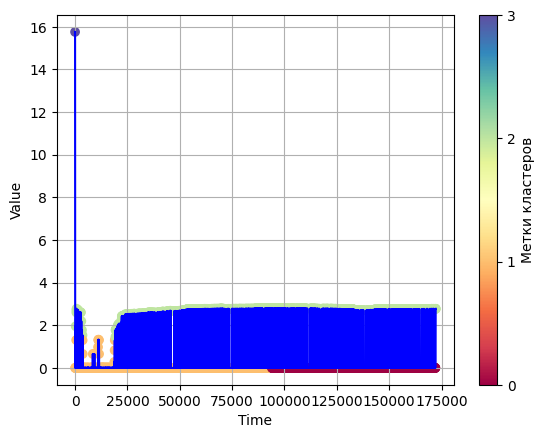

In [ ]:
plot_LR_results(data, cluster_labels, filtered_data, clustered_values)

In [ ]:
clustered_cofs

{np.int64(0): np.float64(0.0),
 np.int64(1): np.float64(-6.569136531868001e-07),
 np.int64(2): np.float64(1.8593755996637776e-06),
 np.int64(3): np.float64(0.0)}

In [ ]:
data

array([[0.00000000e+00, 1.57523235e+01],
       [6.00000000e+01, 0.00000000e+00],
       [1.20000000e+02, 0.00000000e+00],
       ...,
       [1.72140000e+05, 2.77090100e+00],
       [1.72200000e+05, 2.77090100e+00],
       [1.72260000e+05, 2.77090100e+00]])

In [ ]:
#Отметили кластер 0 как аномалию, и кластер 1 как норму (метки: 1 - аномалия, 0 - норм)
labels = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
}

## Stage 2

In [ ]:
# Формируем набор тренировочных входных/выходных данных
x_train = []
y_train = []
for cluster in np.unique(cluster_labels):
    x_train.append(clustered_cofs[cluster])
    y_train.append(labels[cluster])

In [ ]:
x_train

[np.float64(0.0),
 np.float64(-6.569136531868001e-07),
 np.float64(1.8593755996637776e-06),
 np.float64(0.0)]

In [ ]:
y_train

[0, 0, 0, 0]

In [ ]:
if y_train.all() == 1:
    print('kke')
y_train

array([0, 0, 0, 0])

In [ ]:
# Поиск лучшего порога отсечения
x_train = np.array(x_train)
y_train = np.array(y_train)
best_alpha = model.evaluate_thresholds(x_train, y_train)

In [ ]:
x_train

array([ 0.00000000e+00, -6.56913653e-07,  1.85937560e-06,  0.00000000e+00])

In [ ]:
best_alpha

np.float64(1.8593755996637776e-06)

In [ ]:
'''
best_alpha тоже сохраняем, оно потребуется для тестирования модели и в целом инференса
'''
best_alpha

-3.978472372666286e-05

Для данного набора данных нашли лучший порог отсечения.
Чем больше будет данных для данного датчика, тем точнее будет отобран порог для отсечения на всех тестовых данных

# Тестирование

Загружаем новый набор данных  
Можно любую длительность подавать

In [ ]:
# Допустим тут просто другую дату укажем
device_name = 'Токовый ремни  Афл3.1'
date_threshold = '2024-12-26 12:00:00'

In [ ]:
query = '''
SELECT *
FROM sensor_data
WHERE device = %s AND timestamp > %s
'''

In [ ]:
result = client.query(query, (device_name, date_threshold))

In [ ]:
rows = result.result_rows
columns = result.column_names
df = pd.DataFrame(rows, columns=columns)

In [ ]:
model = TSTrendDetection(bandwidth = 1.0)

In [ ]:
df_input = pd.DataFrame()

In [ ]:
df_input[['time','value']] = df[['timestamp','amperage']].copy()

In [ ]:
# Если есть skip_window, то ВР группируется по этому параметру.
# Пример есть 3 наблюдения за 1 минуту (1 min 12 sec: 5) (1 min 36 sec: 7) (1 min 47 sec: 9)
# Три наблюдения группируется в одно (1 min 0 sec: 7)
df_down_sampled = model.downsample(df_input, smoothing_window = 10*60, skip_window = '60s')

# smoothing_window - сглаживание ВР
# skip_window - группировка по времени ВР

In [ ]:
df_down_sampled['time'] = pd.to_timedelta(df_down_sampled.time - df_down_sampled.time.iloc[0], unit='s')

In [ ]:
%%time
# Такой же формат входных данных как и в model.fit_mean_shift(df_down_sampled)
# Новые данные так же разбиваются на кластеры, определяются ЛР для кластеров, наклоны лр сравниваются с best_alpha
# Если какой-то наклон > best_alpha -> аномалия
y_pred = model.predict(None, (df_down_sampled, best_alpha))

CPU times: user 4.09 s, sys: 47.1 ms, total: 4.14 s
Wall time: 7.09 s


Могу ещё сделать, так чтобы model.predict возвращал не только predict'ы но и сами кластеры, но это так, на будущее  

In [ ]:
# Если хоть одна 1 есть, то аномалия в тестовом ряде обноружена, сигналим об этом
(y_pred == 1).any()

True